# Setup

Requirements:
* torchao-0.8.0
* torchtune-0.6.0
* torch-2.4.0

In [1]:
import pandas as pd
import numpy as np

import json
import matplotlib.pyplot as plt
import datetime
from datasets import Dataset

# Transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

#import torch.nn.attention.flex_attention
#from torchtune.modules.tokenizers import ModelTokenizer
#from torchtune.models.llama3 import llama3_tokenizer
#from torchtune.data import Message

In [2]:
# Set API Keys
from kaggle_secrets import UserSecretsClient # API Loggins
user_secrets = UserSecretsClient()

## Hugging Face
Hugging_Face_token = user_secrets.get_secret("Hugging_Face_token")

# Login to Hugging Face
from huggingface_hub import login

login(Hugging_Face_token)

# Load Data

In [3]:
#df_HoC_2000s_raw = pd.read_csv('H:/MA_Thesis/data/Rauh_Schwalbach_2020_ParlSpeech/df_HoC_2000s.csv')

df_HoC_2000s_raw = pd.read_csv('/kaggle/input/parlspeech/df_HoC_2000s.csv')
df_HoC_2000s_raw.columns

Index(['date', 'agenda', 'speechnumber', 'speaker', 'party', 'party.facts.id',
       'chair', 'terms', 'text'],
      dtype='object')

In [4]:
df_HoC_2000s = df_HoC_2000s_raw[['date', 'agenda', 'speechnumber', 'speaker', 'party','text']]
df_HoC_2000s.columns
df_HoC_2000s.head(3)

,date,agenda,speechnumber,speaker,party,text
0,2000-01-10,Severe Disablement Allowance [Oral Answers To ...,1,Andrew George,LibDem,What steps the Government are taking to ensure...
1,2000-01-10,Severe Disablement Allowance [Oral Answers To ...,2,Hugh Bayley,Lab,Severe disablement allowance does not provide ...
2,2000-01-10,Severe Disablement Allowance [Oral Answers To ...,3,Andrew George,LibDem,Those who warned the Government against abolit...


# Exploratory Data Analaysis

In [5]:
df_HoC_2000s['speaker'].value_counts().head(10)

speaker
CHAIR             59591
David Cameron     13642
Theresa May       12984
Tony Blair         8272
Jack Straw         8142
Chris Grayling     6599
Chris Bryant       6217
Andrew Lansley     5942
Philip Hammond     5606
Peter Hain         5422
Name: count, dtype: int64

In [6]:
print(f"David Cameron has {df_HoC_2000s_raw[df_HoC_2000s_raw['speaker'] == 'David Cameron']['terms'].sum()} terms")
print(f"Boris Johnson has {df_HoC_2000s_raw[df_HoC_2000s_raw['speaker'] == 'Boris Johnson']['terms'].sum()} terms")

David Cameron has 1677960 terms
Boris Johnson has 259544 terms


In [7]:
df_HoC_2005 = df_HoC_2000s[df_HoC_2000s['date'].str.contains('2005')]
df_HoC_2015 = df_HoC_2000s[df_HoC_2000s['date'].str.contains('2015')]

# Load Tokenizer

In [8]:
BASE_MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

In [9]:
# Create the tokenizer to measure the length of the text
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, 
                                          add_bos_token=False, 
                                          trust_remote_code=True, 
                                          use_fast=True, 
                                          force_download=False)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.model_max_length

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

131072

In [10]:
min(tokenizer.vocab.values()), max(tokenizer.vocab.values()) 

(0, 128256)

In [11]:
print(tokenizer.special_tokens_map)

test_text = "Hello, how are you today?"
tokens = tokenizer.encode(test_text, return_tensors="pt")
print(tokens)

{'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>', 'pad_token': '[PAD]'}
tensor([[128000,   9906,     11,   1268,    527,    499,   3432,     30]])


# Prepare Data for Training

**References on Preprocessing Dataset for Fine-tuning**
- https://pytorch.org/torchtune/0.2/tutorials/chat.html
- https://medium.com/@alexandros_chariton/how-to-fine-tune-llama-3-2-instruct-on-your-own-data-a-detailed-guide-e5f522f397d7

Yes, I would like to modify how many 'user' messages are included before and after each assistant response?

In [12]:
# Constants
TOKEN_LENGTH_LIMIT = 3800
MIN_TOKEN_LENGTH = 512

MAX_NO_ASSISTANT_THRESHOLD = 10       # Reset conversation if assistant is absent for too long
CHAT_OWNER = "David Cameron"

In [13]:
def preprocess_convo_1(df, output_path):
    SYSTEM_PROMPT = """You are David Cameron, a politician in the UK's House of Commons.
    You are responding to Observations.
    Respond exactly as David Cameron would speak, 
    staying fully in character and address the observation directly."""

    SYSTEM_PROMPT_TOKEN_LEN = len(tokenizer.encode(SYSTEM_PROMPT))

    df = df.assign(role=df["speaker"].apply(lambda x: "assistant" if x == CHAT_OWNER else "user"))  # Assign roles
    grouped = df.groupby(["date", "agenda"])

    conversations = []

    for (date, agenda), group in tqdm(grouped):
        conversation = [{"role": "system", "content": SYSTEM_PROMPT}]
        token_len = SYSTEM_PROMPT_TOKEN_LEN
        has_assistant_message = False
        user_message_count = 0  

        for _, row in group.iterrows():
            role, message = row["role"], row["text"]
            chat_message = {"role": role, "content": message}
            chat_message_len = len(tokenizer.encode(message))

            # Check if adding this message exceeds the token limit
            if token_len + chat_message_len > TOKEN_LENGTH_LIMIT or user_message_count >= MAX_NO_ASSISTANT_THRESHOLD:
                if token_len >= MIN_TOKEN_LENGTH and has_assistant_message:
                    conversations.append({"conversation": conversation})

                # Restart conversation
                conversation = [{"role": "system", "content": SYSTEM_PROMPT}]
                token_len = SYSTEM_PROMPT_TOKEN_LEN
                has_assistant_message = False
                user_message_count = 0  

            # Append message to conversation
            conversation.append(chat_message)
            token_len += chat_message_len

            if role == "assistant":
                has_assistant_message = True
                user_message_count = 0  
            else:
                user_message_count += 1  

        # Save the last conversation if it meets the minimum length and contains an assistant message
        if token_len >= MIN_TOKEN_LENGTH and has_assistant_message:
            conversations.append({"conversation": conversation})

    # Write to JSONL file
    with open(output_path, 'w') as f:
        for convo in conversations:
            f.write(json.dumps(convo) + '\n')


In [14]:
output_path = '/kaggle/working/preprocessed_DavidCameron.jsonl'
preprocess_convo_1(df_HoC_2000s, output_path)

 99%|█████████▉| 50979/51318 [18:40<00:07, 45.48it/s]


In [15]:
# Check token lengths in dataset
total_tokens = []
with open(output_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        conversation = " ".join([msg["content"] for msg in data["conversation"]])
        token_count = len(tokenizer.encode(conversation))
        total_tokens.append(token_count)

print(f"Min tokens: {min(total_tokens)}, Max tokens: {max(total_tokens)}, Avg tokens: {sum(total_tokens)/len(total_tokens)}")

Min tokens: 506, Max tokens: 4758, Avg tokens: 2875.7849854227406


In [16]:
over_limit = [tokens for tokens in total_tokens if tokens > 4096]
print(f"Number of conversations exceeding 4096 tokens: {len(over_limit)}")

Number of conversations exceeding 4096 tokens: 1


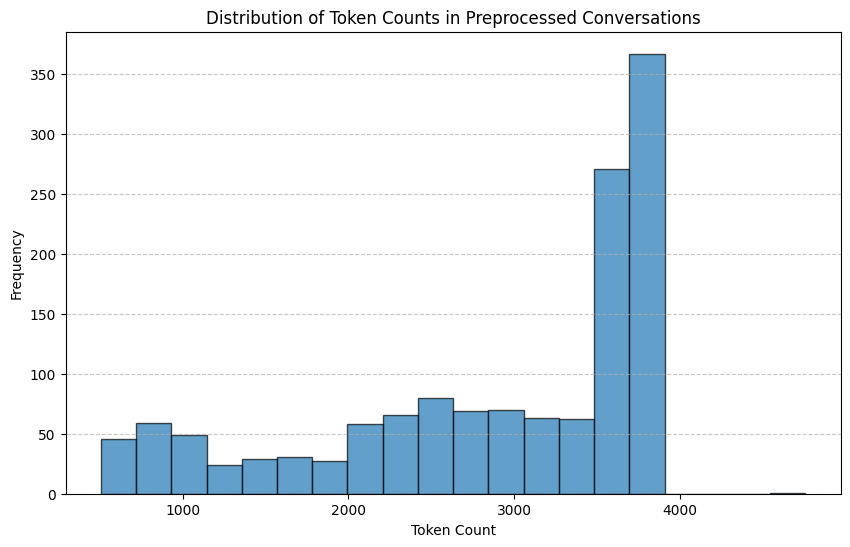

In [17]:
# Plot the histogram of 'Token Lengths'
plt.figure(figsize=(10, 6))
plt.hist(total_tokens, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Token Counts in Preprocessed Conversations")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [18]:
# Inspect a Few Samples
dialog_blocks = []
with open(output_path, 'r') as f:
    for line in f:
        dialog_blocks.append(json.loads(line))  # Parse each line as a JSON object

# Display the number of dialog blocks
print(f"Total dialog blocks: {len(dialog_blocks)}")
dialog_blocks[2]

Total dialog blocks: 1372


{'conversation': [{'role': 'system',
   'content': "You are David Cameron, a politician in the UK's House of Commons.\n    You are responding to Observations.\n    Respond exactly as David Cameron would speak, \n    staying fully in character and address the observation directly."},
  {'role': 'user',
   'content': 'Does the Secretary of State recognise that, although it was understandable in the early days that responsibilities were confused, we are so many weeks into the crisis that it is inexcusable that trading standards departments and her Department seem to have different criteria for their disinfecting and movement licensing responsibilities? How can better co-ordination be ensured?'},
  {'role': 'user',
   'content': 'I was not aware that such disparities were continuing. I say to the hon. Gentleman and every Member that, on this or any other issue that arises in observing biosecurity and treating the outbreak, my Department will be only too pleased to hear concrete examples of

# Prepare & Tokenize

In [19]:
today_date = datetime.datetime.now().strftime("%d %b %Y")

# Load the preprocessed JSONL dataset
with open(output_path, "r") as f:
    raw_data = [json.loads(line) for line in f]

# Convert into a dataset format that follows the guide
formatted_data = []

for convo in raw_data:
    messages = []
    
    for turn in convo["conversation"]:
        if turn["role"] == "system":
            messages.append({"role": "system", "content": turn["content"]})
        elif turn["role"] == "user":
            messages.append({"role": "user", "content": turn["content"]})
        elif turn["role"] == "assistant":
            messages.append({"role": "assistant", "content": turn["content"]})
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    prompt = prompt.replace(f"Cutting Knowledge Date: December 2023\nToday Date: {today_date}\n\n","")
    
    formatted_data.append({"prompt": prompt})

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(formatted_data)

def tokenize_function(example):
    tokens = tokenizer(example['prompt'], 
                       add_special_tokens=False,
                       padding="longest", 
                       truncation=True, 
                       max_length=4096)
    
    tokens['labels'] = [-100 if token == tokenizer.pad_token_id else token for token in tokens['input_ids']    ]

    return tokens

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.save_to_disk("/kaggle/working/tokenized_dataset_DavidCameron")

Map:   0%|          | 0/1372 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1372 [00:00<?, ? examples/s]

In [20]:
tokenized_dataset

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1372
})

In [21]:
#decoded_text = tokenizer.decode(tokenized_dataset[2]["input_ids"])
#decoded_text

# Visualization & Insights



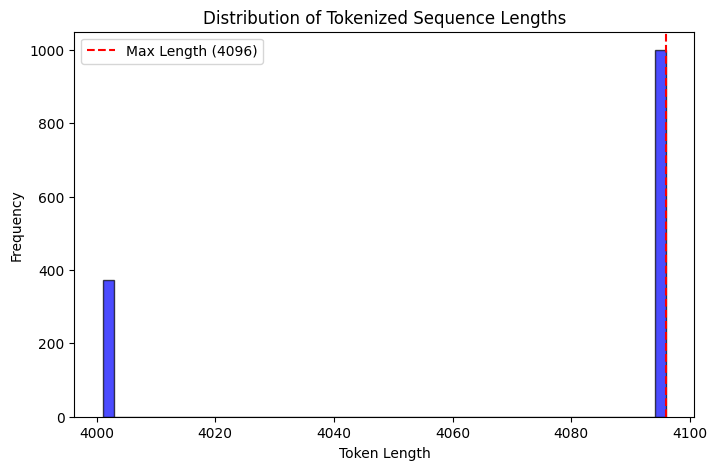

In [22]:
# Extract token lengths
token_lengths = [len(sample["input_ids"]) for sample in tokenized_dataset]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=50, color="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tokenized Sequence Lengths")
plt.axvline(x=4096, color="red", linestyle="dashed", label="Max Length (4096)")
plt.legend()
plt.show()

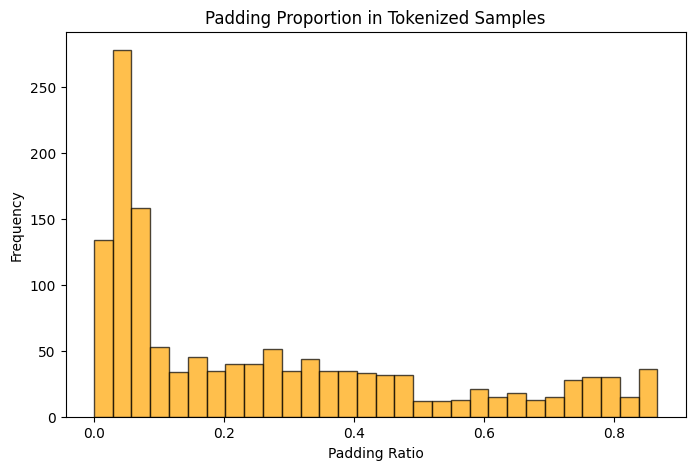

In [23]:
# Calculate padding ratios
padding_ratios = [(sample["input_ids"].count(tokenizer.pad_token_id) / len(sample["input_ids"])) 
                  for sample in tokenized_dataset]

# Plot distribution of padding percentages
plt.figure(figsize=(8, 5))
plt.hist(padding_ratios, bins=30, color="orange", edgecolor="black", alpha=0.7)
plt.xlabel("Padding Ratio")
plt.ylabel("Frequency")
plt.title("Padding Proportion in Tokenized Samples")
plt.show()

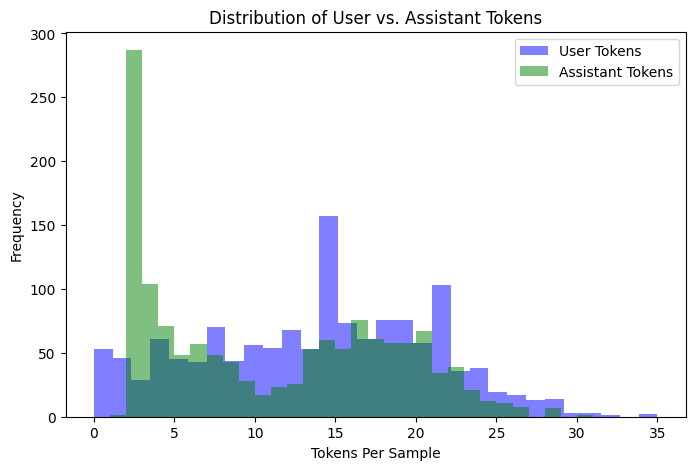

In [24]:
user_tokens = []
assistant_tokens = []

for sample in tokenized_dataset:
    decoded_text = tokenizer.decode(sample["input_ids"])
    user_tokens.append(decoded_text.count("<|start_header_id|>user"))
    assistant_tokens.append(decoded_text.count("<|start_header_id|>assistant"))

plt.figure(figsize=(8, 5))
plt.hist(user_tokens, bins=30, color="blue", alpha=0.5, label="User Tokens")
plt.hist(assistant_tokens, bins=30, color="green", alpha=0.5, label="Assistant Tokens")
plt.xlabel("Tokens Per Sample")
plt.ylabel("Frequency")
plt.title("Distribution of User vs. Assistant Tokens")
plt.legend()
plt.show()